In [ ]:
# isntalling icevision library https://airctic.com/0.8.1/
!wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
!bash install_colab.sh

In [ ]:
# Restart kernel after installation
exit()

In [ ]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt 
import numpy as np
import json
from glob import glob
from glob import iglob
from imutils import paths
from icevision.all import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_DIR = Path("/content/drive/My Drive/clearquote")

In [ ]:
DATA_DIR

Path('/content/drive/My Drive/clearquote')

In [ ]:
TRAIN_DIR = DATA_DIR /"ShelfImages/train"
TEST_DIR = DATA_DIR /"ShelfImages/test"

In [ ]:
cols = ["image_name", "x_i", "y_i", "w_i", "h_i", "b_i"]
df = pd.read_csv(DATA_DIR / "annotations.csv", names = cols)
df.head()

image_name   x_i   y_i   w_i   h_i  b_i
0  C1_P01_N1_S2_1.JPG  1008  1552  1260  1928    0
1  C1_P01_N1_S2_1.JPG  1028   928  1280  1304    0
2  C1_P01_N1_S2_1.JPG    24   872   268  1264    0
3  C1_P01_N1_S2_1.JPG   280  1568   532  1944    0
4  C1_P01_N1_S2_1.JPG   292   872   544  1248    0

In [ ]:
!ls 

drive  install_colab.sh  sample_data


In [ ]:
# Grab the image names belonging to the train and test sets

train_image_names = list(os.path.basename(x) for x in glob('/content/drive/My Drive/clearquote/ShelfImages/train/*.JPG'))
test_image_names = list(os.path.basename(x) for x in glob('/content/drive/My Drive/clearquote/ShelfImages/test/*.JPG'))

print(len(train_image_names), len(test_image_names))

283 71


In [ ]:
# Create two different dataframes from train and test sets
train_df = df[ df["image_name"].isin(train_image_names)]
test_df =  df[~ df["image_name"].isin(train_image_names)]
print(len(np.unique(train_df["image_name"])), len(np.unique(test_df["image_name"])))

283 71


In [ ]:
# getting image width and height from each image and adding to DF
def img_s(row):
  im = Image.open(str(TRAIN_DIR) + '/' + str(row.image_name))
  width, height = im.size
  row['width'],row['height'] = width , height
  return row


In [ ]:
train_df = train_df.apply(img_s, axis = 1)

In [ ]:
train_df.head()

image_name   x_i   y_i   w_i   h_i  b_i  width  height
0  C1_P01_N1_S2_1.JPG  1008  1552  1260  1928    0   1363    2188
1  C1_P01_N1_S2_1.JPG  1028   928  1280  1304    0   1363    2188
2  C1_P01_N1_S2_1.JPG    24   872   268  1264    0   1363    2188
3  C1_P01_N1_S2_1.JPG   280  1568   532  1944    0   1363    2188
4  C1_P01_N1_S2_1.JPG   292   872   544  1248    0   1363    2188

In [ ]:
len(train_df)

10536

In [ ]:
# droping corrupt images
train_df_f =train_df.drop(train_df.index[8200:8350])

In [ ]:
len(train_df_f)

10386

In [168]:
# since we are detecting only if the product exists or not we will ignore all the brands and 
class_map = ClassMap(['cig'])
class_map

<ClassMap: {'background': 0, 'cig': 1}>

In [ ]:
#creating a parser
template_record = ObjectDetectionRecord()

In [ ]:
# prints all the neccesasry steps to create a parser form the dataframe.
Parser.generate_template(template_record)

class MyParser(Parser):
    def __init__(self, template_record):
        super().__init__(template_record=template_record)
    def __iter__(self) -> Any:
    def __len__(self) -> int:
    def record_id(self, o: Any) -> Hashable:
    def parse_fields(self, o: Any, record: BaseRecord, is_new: bool):
        record.set_filepath(<Union[str, Path]>)
        record.set_img_size(<ImgSize>)
        record.detection.set_class_map(<ClassMap>)
        record.detection.add_labels(<Sequence[Hashable]>)
        record.detection.add_bboxes(<Sequence[BBox]>)


In [ ]:
class shelfParser(Parser):
  def __init__(self, template_record , data_dir):
    super().__init__(template_record = template_record)

    self.data_dir = data_dir
    self.df = train_df_f
    self.class_map = ClassMap(['cig'])

  def __iter__(self) -> Any:
    for o in self.df.itertuples():
      yield o
  
  def __len__(self) -> int:
    return len(self.df)
  
  def record_id (self, o) -> Hashable:
    return o.image_name
  
  def parse_fields(self, o, record , is_new):
    if is_new:
      record.set_filepath(self.data_dir/"ShelfImages/train"/o.image_name)
      record.set_img_size(ImgSize(width=o.width, 
                                height=o.height))
      record.detection.set_class_map(self.class_map)
    
    record.detection.add_bboxes([BBox.from_xyxy(o.x_i, o.y_i, o.w_i, o.h_i)])
    
    record.detection.add_labels(['cig'])


In [ ]:
parser = shelfParser(template_record, DATA_DIR)

In [ ]:
train_records, valid_records = parser.parse()

  0%|          | 0/10386 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/281 [00:00<?, ?it/s]

In [ ]:
train_records[0]

BaseRecord

common: 
	- Filepath: /content/drive/My Drive/clearquote/ShelfImages/train/C2_P04_N3_S3_1.JPG
	- Img: None
	- Record ID: C2_P04_N3_S3_1.JPG
	- Image size ImgSize(width=2592, height=1530)
detection: 
	- Class Map: <ClassMap: {'background': 0, 'cig': 1}>
	- Labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
	- BBoxes: [<BBox (xmin:100, ymin:1068, xmax:260, ymax:1348)>, <BBox (xmin:1028, ymin:712, xmax:1216, ymax:984)>, <BBox (xmin:1092, ymin:1120, xmax:1256, ymax:1384)>, <BBox (xmin:1204, ymin:716, xmax:1392, ymax:988)>, <BBox (xmin:1224, ymin:172, xmax:1408, ymax:500)>, <BBox (xmin:1368, ymin:716, xmax:1556, ymax:988)>, <BBox (xmin:1404, ymin:220, xmax:1588, ymax:516)>, <BBox (xmin:1412, ymin:1164, xmax:1576, ymax:1420)>, <BBox (xmin:1536, ymin:728, xmax:1724, ymax:1000)>, <BBox (xmin:1572, ymin:1176, xmax:1736, ymax:1432)>, <BBox (xmin:1576, ymin:224, xmax:1772, ymax:516)>, <BBox (xmin:1736, ym

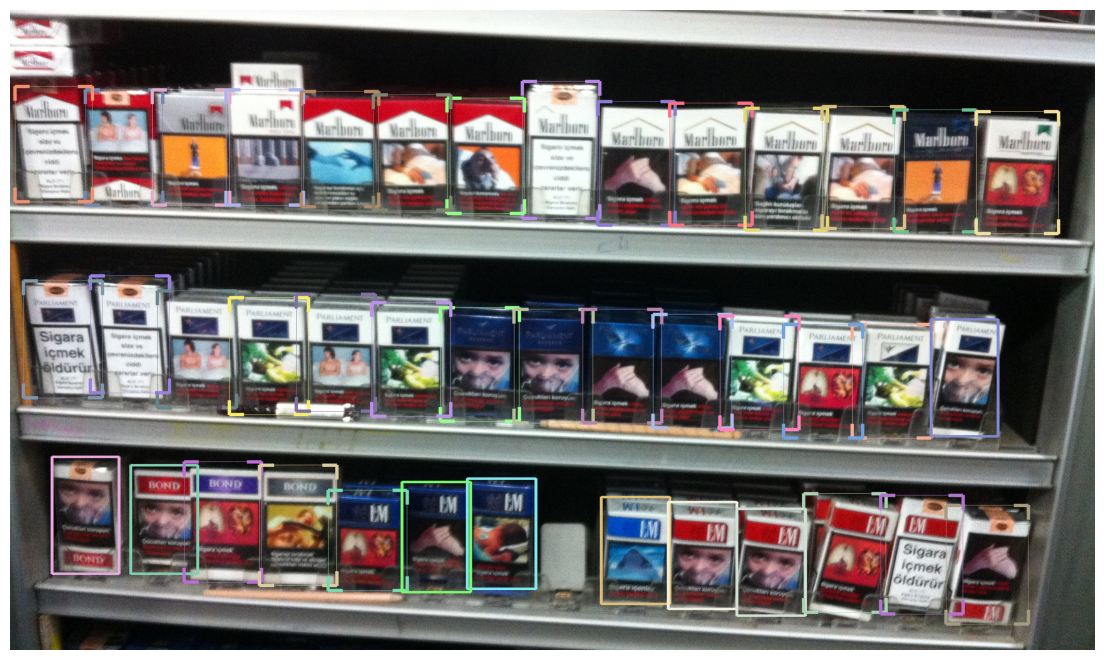

In [ ]:
show_record(train_records[0], display_label=False, figsize=(14, 10))

In [ ]:
# image default agumentations and transformations using albumentations https://albumentations.ai/docs/
image_size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

In [ ]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

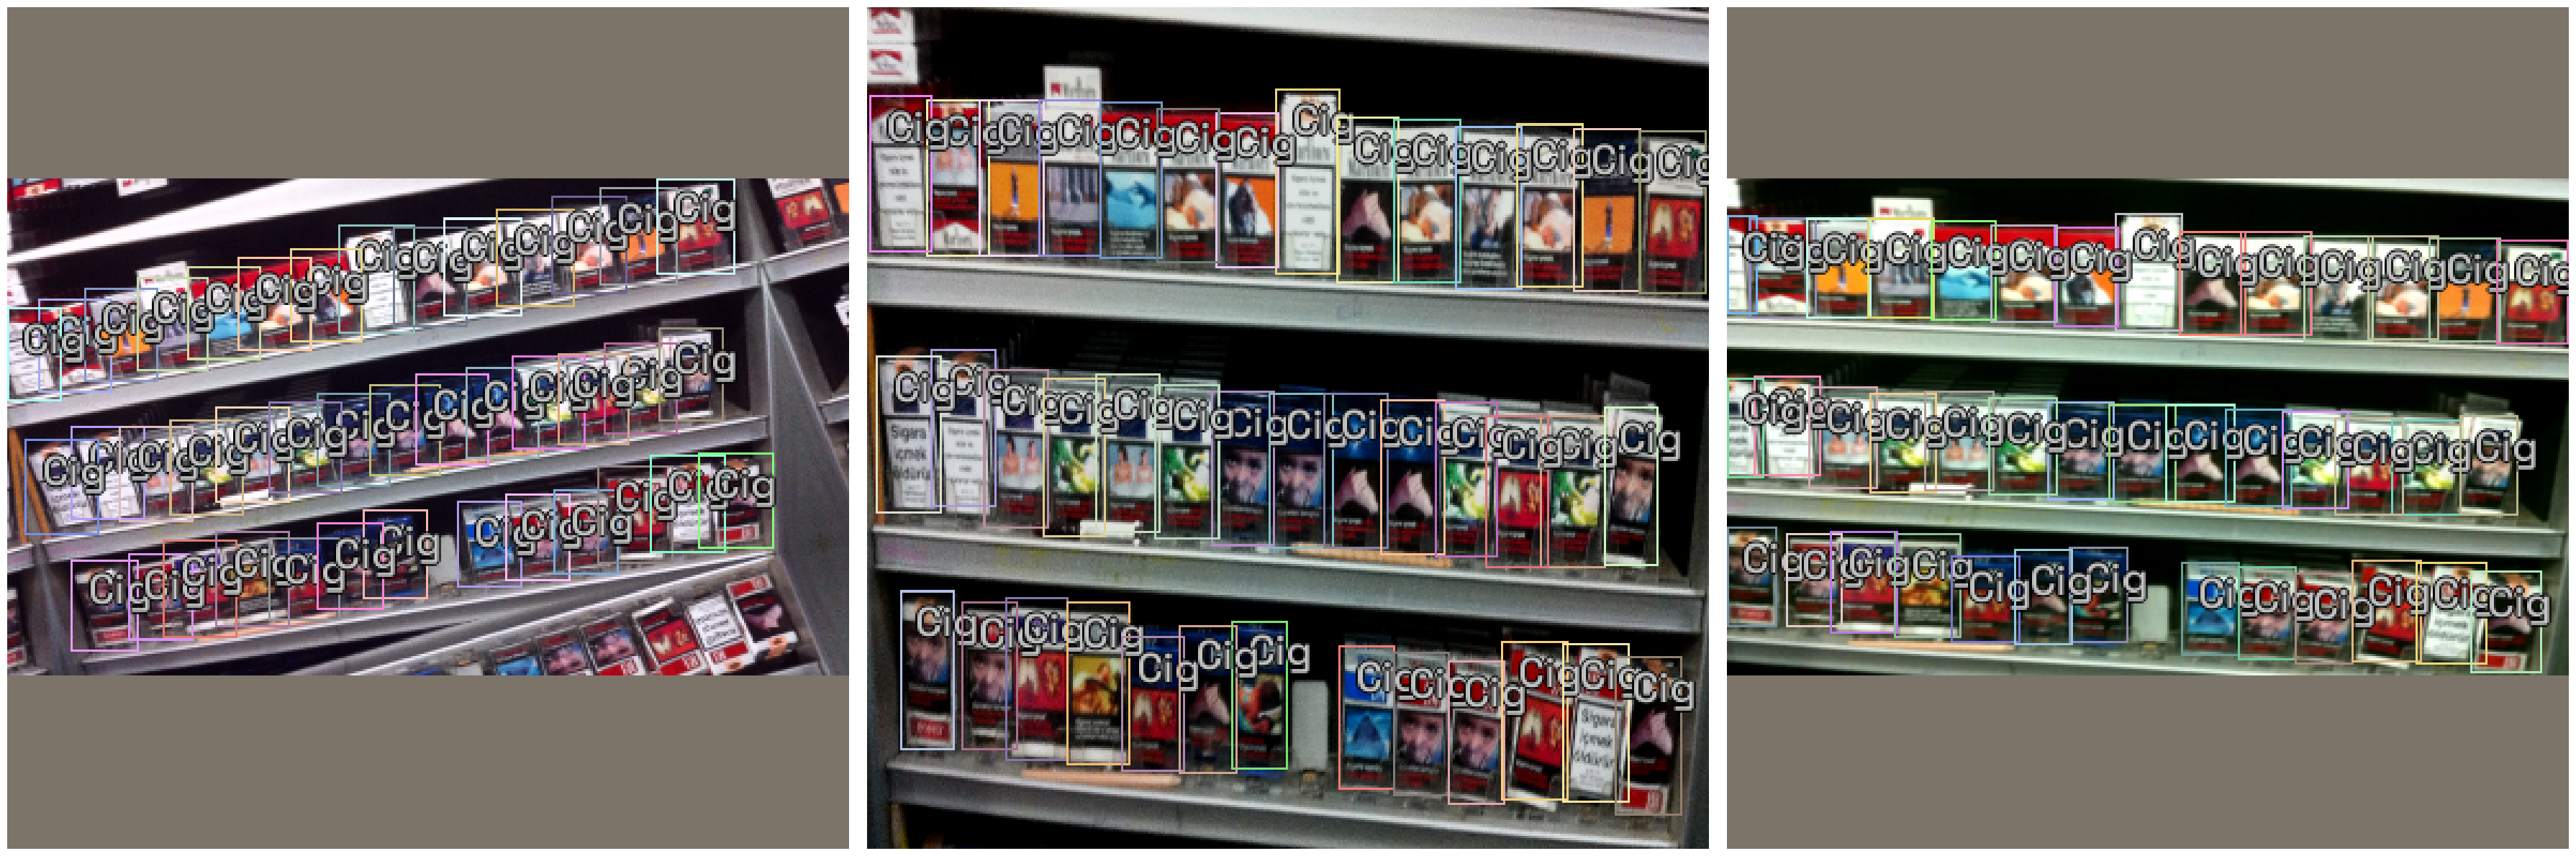

In [ ]:
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3)

Detection network = ***RETINANET*** <br>
backbone arch = ***resnet50*** 





In [ ]:
# model and backbone 
model_type = models.mmdet.retinanet
backbone = model_type.backbones.resnet50_fpn_1x(pretrained=True)

In [ ]:
extra_args = {}

In [ ]:
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map), **extra_args) 

In [ ]:
# Data Loaders
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


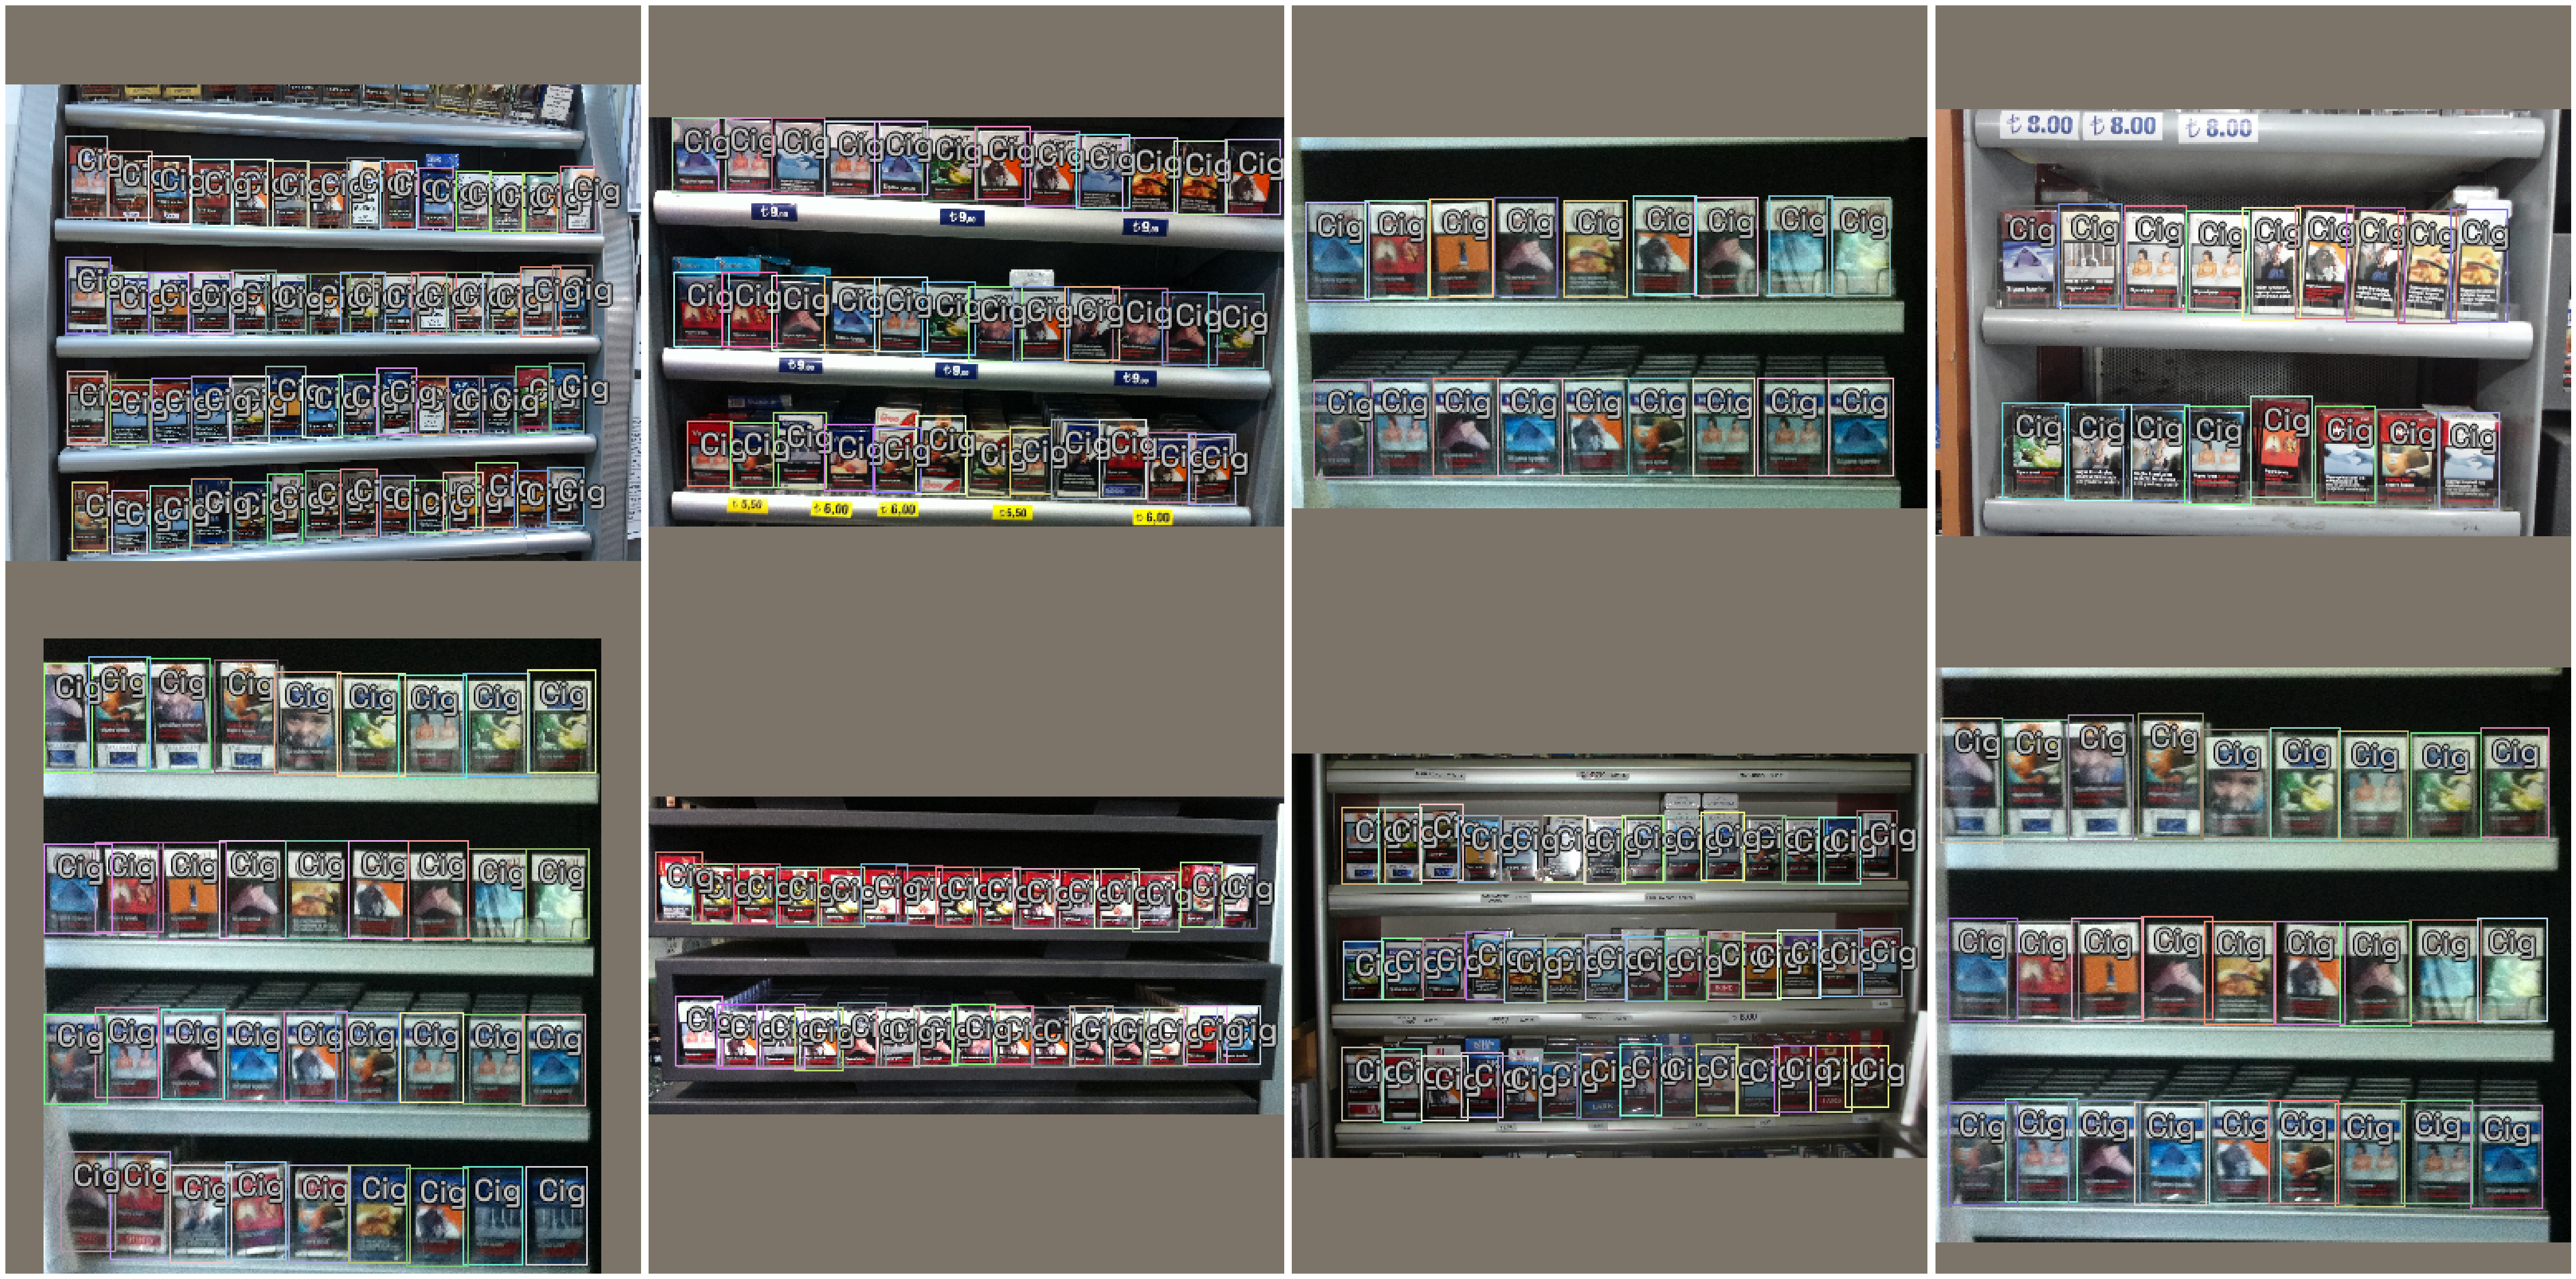

In [ ]:
# show batch
model_type.show_batch(first(valid_dl), ncols=4)

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [ ]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


SuggestedLRs(valley=0.00010964782268274575)

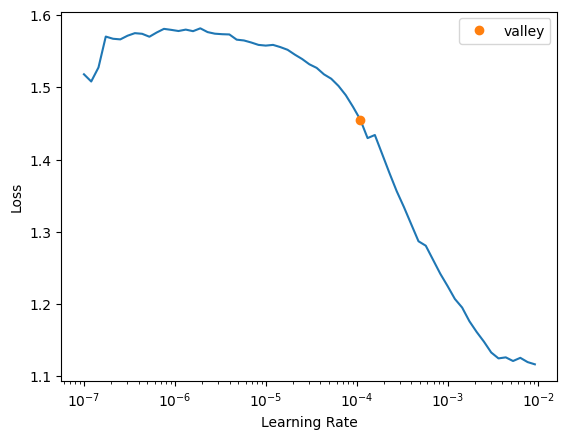

In [ ]:
learn.lr_find()

**Model training**

In [ ]:
learn.fine_tune(20, 1e-04, freeze_epochs=1)

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


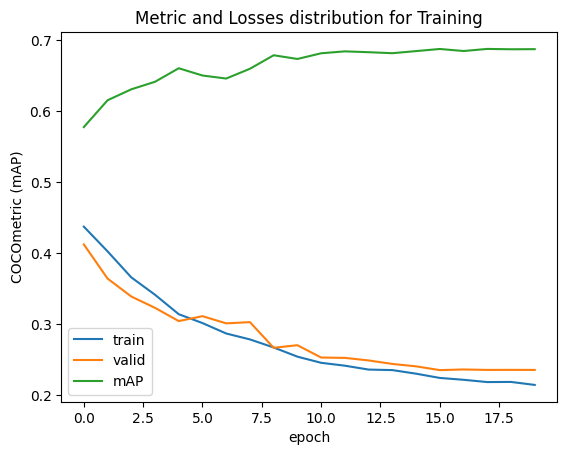

In [164]:
plt.plot(L(learn.recorder.values).itemgot(), label = [])
plt.xlabel('epoch')
plt.ylabel('COCOmetric (mAP)')
plt.title('Metric and Losses distribution for Training')
plt.legend(['train','valid','mAP']);

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


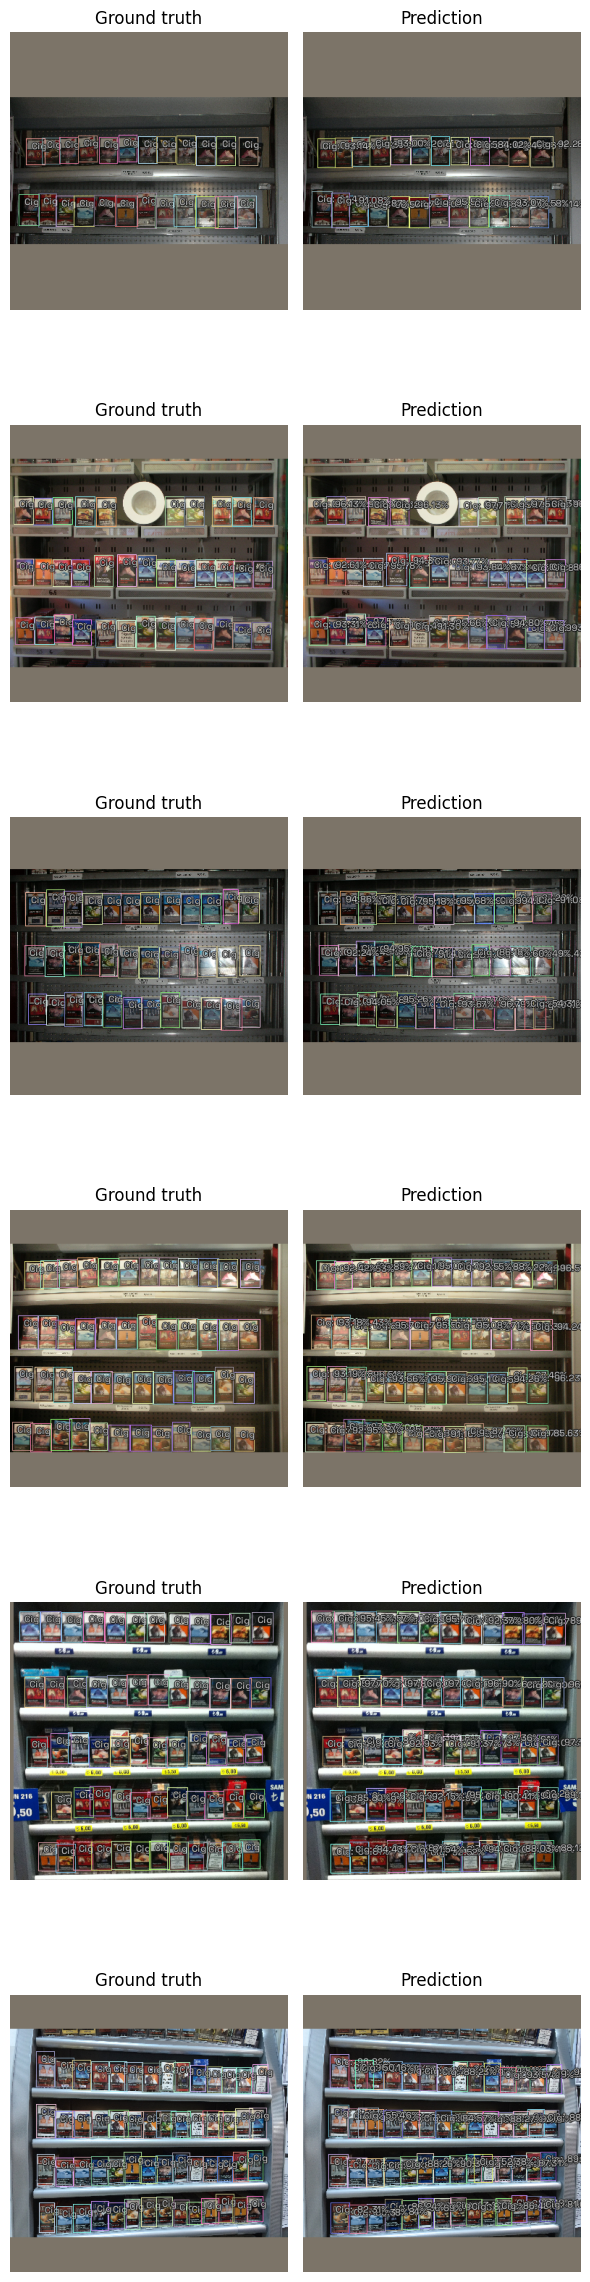

In [ ]:
model_type.show_results(model, valid_ds, detection_threshold=.5)

Inference:predicting on ***TEST images***


In [ ]:
# creating a series of arrays of all the test images
imgs = []
img_files = glob('/content/drive/My Drive/clearquote/ShelfImages/test/*.JPG')
for i in img_files:
  imgs.append(np.array(Image.open(i)))

In [169]:
# basic image transformations
infer_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=384), tfms.A.Normalize()])
infer = Dataset.from_images(imgs, infer_tfms, class_map=class_map)

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


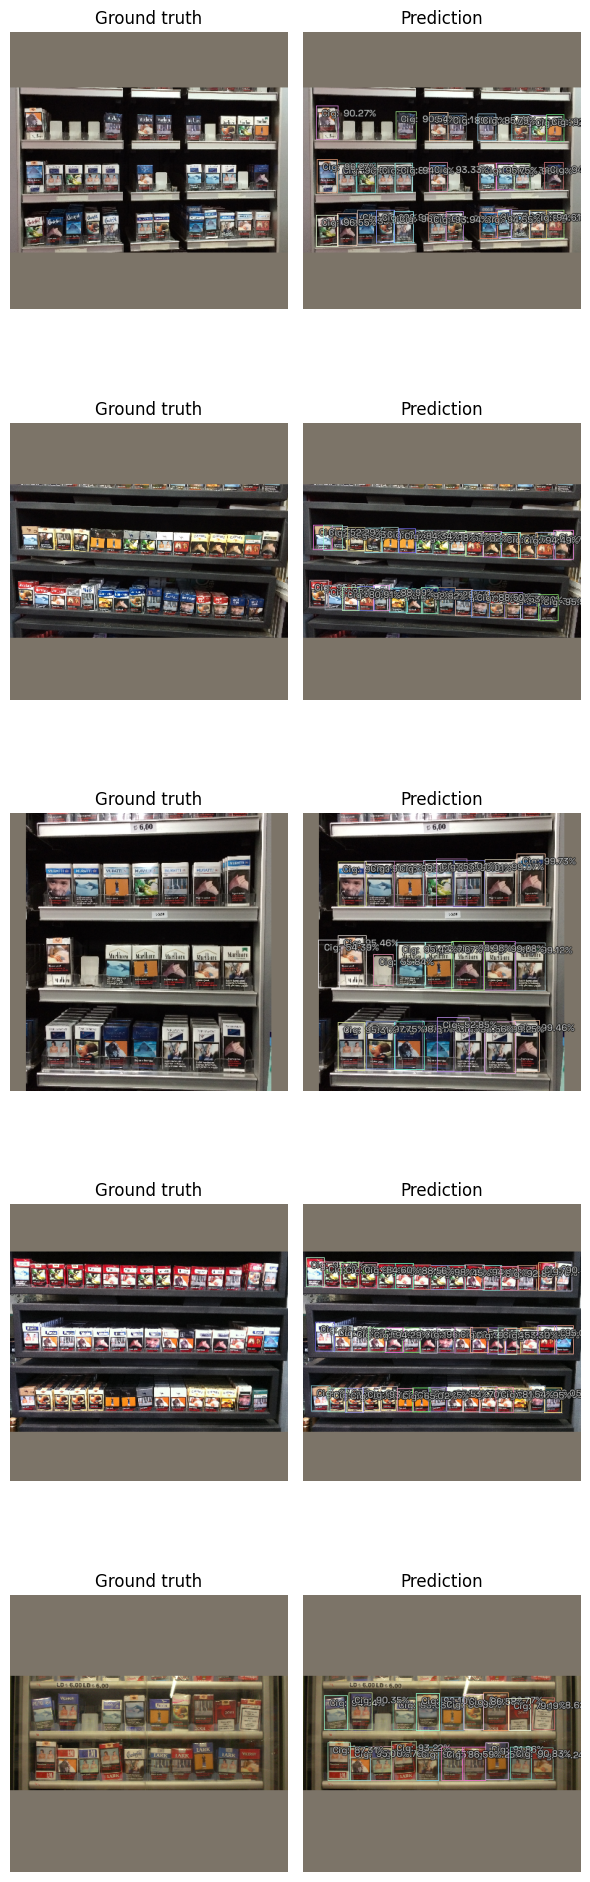

In [170]:
# prediction using trained model and visualizing the results
preds = model_type.predict(model, infer, keep_images=True)
show_preds(preds=preds[:5])

In [145]:
dicts = {}
for i in range(len(preds)):
  dicts["shelf_"+os.path.basename(glob('/content/drive/My Drive/clearquote/ShelfImages/test/*.JPG')[i])] = len(preds[i].pred.detection.bboxes)
  # print ("image name {} and number of products {}".format(os.path.basename(glob('/content/drive/My Drive/clearquote/ShelfImages/test/*.JPG')[i]) ,
                                                            #  len(preds[i].pred.detection.bboxes)))

In [144]:
#creating a json file of image names and number of products
with open("/content/image2products.json", "w") as outfile:
    json.dump(dicts, outfile)

calculating ***recall*** and ***precision*** on the model. 

In [ ]:
# predicting on validation dataset to get confusion matrix
infer_dl = model_type.infer_dl(valid_ds, batch_size=4, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True, detection_threshold = 0.5)

  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


In [ ]:
#confusion matrix
cm = SimpleConfusionMatrix()
cm.accumulate(preds)
_ = cm.finalize()


In [ ]:
cm.class_map

<ClassMap: {'background': 0, 'cig': 1}>

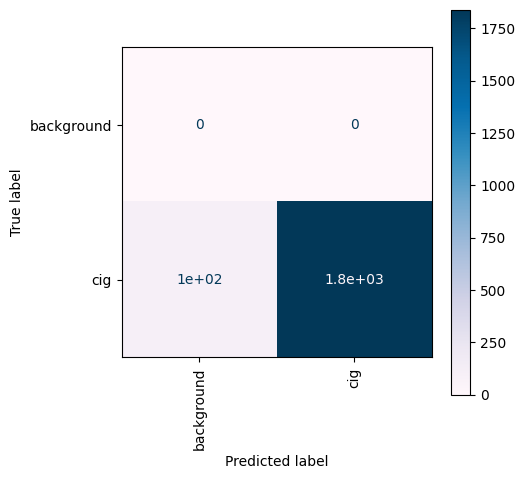

In [119]:
cm.plot(figsize=5, normalize = None)

In [122]:
cm.confusion_matrix

array([[   0,    0],
       [ 103, 1838]])

TP = 1838 <br>
FN = 103 <br>

TP + FP can be calculated from :

In [124]:
sum([len(pred.pred.detection.bboxes) for pred in preds])

1916

we can calculate recall and precision :<br>
1. *precision* = TP/(TP+FP) = 1838/1916 = 0.9592<br>
2. *recall* = TP/(TP+FN) = 1838/(1838+103) = 0.9469







In [166]:
dicts_s = {
    "mAP":0.687,
    "recall":0.946,
    "precision":0.959
}

In [167]:
#creating a json file of image names and number of products
with open("/content/metrics.json", "w") as outfile:
    json.dump(dicts_s, outfile)